# Copyright 2019 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [2]:
#@title MIT License
#
# Copyright (c) 2017 François Chollet
#
# Permission is hereby granted, free of charge, to any person obtaining a
# copy of this software and associated documentation files (the "Software"),
# to deal in the Software without restriction, including without limitation
# the rights to use, copy, modify, merge, publish, distribute, sublicense,
# and/or sell copies of the Software, and to permit persons to whom the
# Software is furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL
# THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
# FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER
# DEALINGS IN THE SOFTWARE.

# Text classification with TensorFlow Hub: Movie reviews

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/keras/text_classification_with_hub"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/keras/text_classification_with_hub.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/keras/text_classification_with_hub.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/keras/text_classification_with_hub.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
  <td>
    <a href="https://tfhub.dev/s?module-type=text-embedding"><img src="https://www.tensorflow.org/images/hub_logo_32px.png" />See TF Hub models</a>
  </td>
</table>

This notebook classifies movie reviews as *positive* or *negative* using the text of the review. This is an example of *binary*—or two-class—classification, an important and widely applicable kind of machine learning problem.

The tutorial demonstrates the basic application of transfer learning with [TensorFlow Hub](https://tfhub.dev) and Keras.

We'll use the [IMDB dataset](https://www.tensorflow.org/api_docs/python/tf/keras/datasets/imdb) that contains the text of 50,000 movie reviews from the [Internet Movie Database](https://www.imdb.com/). These are split into 25,000 reviews for training and 25,000 reviews for testing. The training and testing sets are *balanced*, meaning they contain an equal number of positive and negative reviews. 

This notebook uses [`tf.keras`](https://www.tensorflow.org/guide/keras), a high-level API to build and train models in TensorFlow, and [`tensorflow_hub`](https://www.tensorflow.org/hub), a library for loading trained models from [TFHub](https://tfhub.dev) in a single line of code. For a more advanced text classification tutorial using `tf.keras`, see the [MLCC Text Classification Guide](https://developers.google.com/machine-learning/guides/text-classification/).

In [3]:
import os
import sys
import numpy as np

import tensorflow as tf
import tensorflow_hub as hub
# import tensorflow_datasets as tfds

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import libraries.mlvislib as mlvs

print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.experimental.list_physical_devices("GPU") else "NOT AVAILABLE")

from IPython.core.display import HTML, display
# Initializing D3 for the entire notebook (this fixes error requiring kernel to load twice)
# (feel free to move this line to anywhere in notebook before visualizations)
display(HTML('<script data-require="d3@3.5.3" data-semver="3.5.3" src="//cdnjs.cloudflare.com/ajax/libs/d3/3.5.3/d3.js"></script>'))

Version:  2.5.0
Eager mode:  True
Hub version:  0.12.0
GPU is available


## Load dataset

The IMDB dataset is available on [imdb reviews](https://www.tensorflow.org/datasets/catalog/imdb_reviews) or on [TensorFlow datasets](https://www.tensorflow.org/datasets). The following code downloads the IMDB dataset to your machine (or the colab runtime):

In [4]:
# Split the training set into 60% and 40%, so we'll end up with 15,000 examples
# for training, 10,000 examples for validation and 25,000 examples for testing.
import ipywidgets as widgets
import pandas as pd

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

dataset = pd.read_csv("dataset/IMDB Dataset.csv")
dataset = dataset[:25000]

dataset.isnull().values.any()
dataset.shape
dataset.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


## Explore the data 

Let's take a moment to understand the format of the data. Each example is a sentence representing the movie review and a corresponding label. The sentence is not preprocessed in any way. The label is an integer value of either 0 or 1, where 0 is a negative review, and 1 is a positive review.

Let's print first 10 examples.

0    One of the other reviewers has mentioned that ...
1    A wonderful little production. <br /><br />The...
2    I thought this was a wonderful way to spend ti...
3    Basically there's a family where a little boy ...
4    Petter Mattei's "Love in the Time of Money" is...
5    Probably my all-time favorite movie, a story o...
6    I sure would like to see a resurrection of a u...
7    This show was an amazing, fresh & innovative i...
8    Encouraged by the positive comments about this...
Name: review, dtype: object

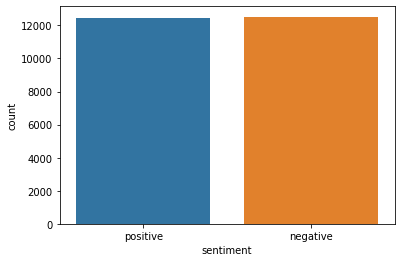

In [5]:
import seaborn as sns

sns.countplot(x='sentiment', data=dataset)
dataset["review"][:9]

## Pre-Processing Data

In [6]:
from sklearn.model_selection import train_test_split
import re

def cleanText(sentence):

    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)

    return sentence

def preProcess(text):
    # Make lower case
    text = text.lower()

    # Replace non-text characters with spaces
    nonText = string.punctuation + ("")
    text = text.translate(str.maketrans(nonText, ' ' * (len(nonText))))

    # Tokenize
    words = text.split()

    return words

#x = []
#sentences = list(dataset['review'])
#for sen in sentences:
#    x.append(cleanText(sen))

y = dataset['sentiment']

y = np.array(list(map(lambda x: 1 if x=="positive" else 0, y)))

x_train, x_test, y_train, y_test = train_test_split(dataset['review'], y, test_size=0.4, random_state=42)

print(x_train)

18930    "Wired" would have to rate as one of the ten w...
2791     A 'Wes Craven presents' movie from 1995, direc...
388      A lovely little B picture with all the usual J...
22764    I am going to go out on a limb, and actually d...
24934    To put in simple words or rather a word, would...
                               ...                        
21575    I enjoyed a lot watching this movie. It has a ...
5390     I can't knock this film too terribly, because ...
860      This production was quite a surprise for me. I...
15795    This is a decent movie. Although little bit sh...
23654    Another very good Mann flick thanks to the fat...
Name: review, Length: 15000, dtype: object


In [7]:
y_test

array([1, 0, 0, ..., 1, 0, 0])

## Build the model

The neural network is created by stacking layers—this requires three main architectural decisions:

* How to represent the text?
* How many layers to use in the model?
* How many *hidden units* to use for each layer?

In this example, the input data consists of sentences. The labels to predict are either 0 or 1.

One way to represent the text is to convert sentences into embeddings vectors. We can use a pre-trained text embedding as the first layer, which will have three advantages:

*   we don't have to worry about text preprocessing,
*   we can benefit from transfer learning,
*   the embedding has a fixed size, so it's simpler to process.

For this example we will use a **pre-trained text embedding model** from [TensorFlow Hub](https://tfhub.dev) called [google/nnlm-en-dim50/2](https://tfhub.dev/google/nnlm-en-dim50/2).

There are many other pre-trained text embeddings from TFHub that can be used in this tutorial:

* [google/nnlm-en-dim128/2](https://tfhub.dev/google/nnlm-en-dim128/2) - trained with the same NNLM architecture on the same data as [google/nnlm-en-dim50/2](https://tfhub.dev/google/nnlm-en-dim50/2), but with a larger embedding dimension. Larger dimensional embeddings can improve on your task but it may take longer to train your model.
* [google/nnlm-en-dim128-with-normalization/2](https://tfhub.dev/google/nnlm-en-dim128-with-normalization/2) - the same as [google/nnlm-en-dim128/2](https://tfhub.dev/google/nnlm-en-dim128/2), but with additional text normalization such as removing punctuation. This can help if the text in your task contains additional characters or punctuation.
* [google/universal-sentence-encoder/4](https://tfhub.dev/google/universal-sentence-encoder/4) - a much larger model yielding 512 dimensional embeddings trained with a deep averaging network (DAN) encoder.

And many more! Find more [text embedding models](https://tfhub.dev/s?module-type=text-embedding) on TFHub.

Let's first create a Keras layer that uses a TensorFlow Hub model to embed the sentences, and try it out on a couple of input examples. Note that no matter the length of the input text, the output shape of the embeddings is: `(num_examples, embedding_dimension)`.

In [8]:
embedding = "https://tfhub.dev/google/nnlm-en-dim50/2"
# universal_sentence_embedding = "https://tfhub.dev/google/universal-sentence-encoder/4"
# hub_layer = hub.KerasLayer(universal_sentence_embedding, input_shape=[], 
#                            dtype=tf.string, trainable=True)
hub_layer = hub.KerasLayer(embedding, input_shape=[], 
                           dtype=tf.string, trainable=True)

Let's now build the full model:

In [9]:
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Activation, Dropout, Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import GlobalMaxPooling1D
from tensorflow.keras.layers import Embedding

model = Sequential()
model.add(hub_layer)
# Adjusting the below value will change the amount of 'bars' loaded into the Barcode Vis
model.add(Dense(16, activation='relu'))
model.add(Dense(1))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 50)                48190600  
_________________________________________________________________
dense (Dense)                (None, 16)                816       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 48,191,433
Trainable params: 48,191,433
Non-trainable params: 0
_________________________________________________________________


The layers are stacked sequentially to build the classifier:

1. The first layer is a TensorFlow Hub layer. This layer uses a pre-trained Saved Model to map a sentence into its embedding vector. The pre-trained text embedding model that we are using ([google/nnlm-en-dim50/2](https://tfhub.dev/google/nnlm-en-dim50/2)) splits the sentence into tokens, embeds each token and then combines the embedding. The resulting dimensions are: `(num_examples, embedding_dimension)`. For this NNLM model, the `embedding_dimension` is 50.
2. This fixed-length output vector is piped through a fully-connected (`Dense`) layer with 16 hidden units.
3. The last layer is densely connected with a single output node.

Let's compile the model.

### Loss function and optimizer

A model needs a loss function and an optimizer for training. Since this is a binary classification problem and the model outputs logits (a single-unit layer with a linear activation), we'll use the `binary_crossentropy` loss function.

This isn't the only choice for a loss function, you could, for instance, choose `mean_squared_error`. But, generally, `binary_crossentropy` is better for dealing with probabilities—it measures the "distance" between probability distributions, or in our case, between the ground-truth distribution and the predictions.

Later, when we are exploring regression problems (say, to predict the price of a house), we will see how to use another loss function called mean squared error.

Now, configure the model to use an optimizer and a loss function:

In [10]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

## Train the model

Train the model for 10 epochs in mini-batches of 512 samples. This is 10 iterations over all samples in the `x_train` and `y_train` tensors. While training, monitor the model's loss and accuracy on the 10,000 samples from the validation set:

### Extracting Data

Here, we define the Callback function used to extact data from the model as it fits.

In [11]:
import libraries.extractioncallback as excb

extractor = excb.CallbackDataExtractor(
    model = model,
    layer = 1,
    validation_data = (x_test, y_test),
    sample_every = 1,
    rec_int_values = True,
    is_bin = True
)

In [12]:
history = model.fit(x_train, y_train, batch_size=512, epochs=10, verbose=1, validation_split=0.2, shuffle=False, callbacks=[extractor])
# No significant gain on testing above the 5th epoch

Epoch 1/10
24/24 [==============================] - 3s 84ms/step - loss: 0.6592 - accuracy: 0.5221 - val_loss: 0.6168 - val_accuracy: 0.5997
Epoch 2/10
24/24 [==============================] - 2s 80ms/step - loss: 0.5665 - accuracy: 0.6585 - val_loss: 0.5353 - val_accuracy: 0.7190
Epoch 3/10
24/24 [==============================] - 2s 79ms/step - loss: 0.4623 - accuracy: 0.7824 - val_loss: 0.4569 - val_accuracy: 0.7853
Epoch 4/10
24/24 [==============================] - 2s 80ms/step - loss: 0.3599 - accuracy: 0.8568 - val_loss: 0.3939 - val_accuracy: 0.8277
Epoch 5/10
24/24 [==============================] - 2s 79ms/step - loss: 0.2715 - accuracy: 0.9030 - val_loss: 0.3525 - val_accuracy: 0.8437
Epoch 6/10
24/24 [==============================] - 2s 79ms/step - loss: 0.2015 - accuracy: 0.9343 - val_loss: 0.3299 - val_accuracy: 0.8577
Epoch 7/10
24/24 [==============================] - 2s 79ms/step - loss: 0.1472 - accuracy: 0.9574 - val_loss: 0.3209 - val_accuracy: 0.8600
Epoch 8/10
24

In [13]:
from sklearn.metrics import classification_report
from sklearn.preprocessing import MinMaxScaler

# make a prediction
testingPredictions = (model.predict(x_test) > 0.5).astype("int32")
confidence_scores = model.predict(x_test, batch_size=512)

# scaling confidence scores to range between 0 and 1 with MinMaxScaler 
scaler = MinMaxScaler(feature_range=[0, 1])
scaler.fit(confidence_scores)
confidence_scores = scaler.transform(confidence_scores)

target_names = ['negative', 'positive']
print(classification_report(y_test, testingPredictions, target_names=target_names))
testingPredictions

              precision    recall  f1-score   support

    negative       0.85      0.88      0.87      5002
    positive       0.88      0.85      0.86      4998

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000



array([[1],
       [0],
       [0],
       ...,
       [1],
       [0],
       [0]], dtype=int32)

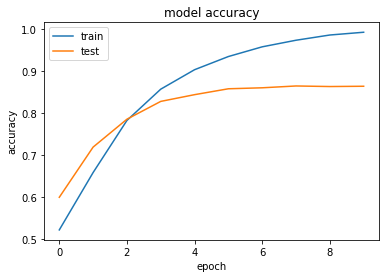

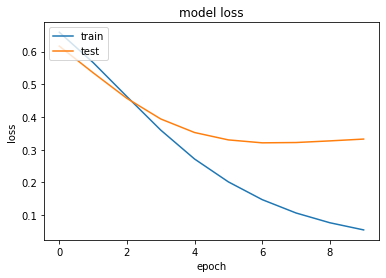

In [14]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

## Evaluate the model

And let's see how the model performs. Two values will be returned. Loss (a number which represents our error, lower values are better), and accuracy.

In [15]:
results = model.evaluate(x_test, y_test, verbose=2)

for name, value in zip(model.metrics_names, results):
  print("%s: %.3f" % (name, value))

313/313 - 1s - loss: 0.3373 - accuracy: 0.8640
loss: 0.337
accuracy: 0.864


This fairly naive approach achieves an accuracy of about 87%. With more advanced approaches, the model should get closer to 95%.

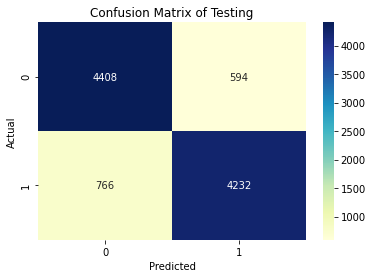

In [16]:
data = {'Actual':    y_test,
        'Predicted': testingPredictions.reshape(len(y_test),)
        }
#print(testingLabels.reshape(len(testingLabels),1))
df = pd.DataFrame(data, columns=['Actual','Predicted'])
confusion_matrix = pd.crosstab(df['Actual'], df['Predicted'], rownames=['Actual'], colnames=['Predicted'])

sns.heatmap(confusion_matrix, annot=True,cmap="YlGnBu", fmt='d').set_title('Confusion Matrix of Testing')
plt.show()

In [17]:
from IPython.core.display import HTML, display


# Writing Epoch Data to JSON...
output_directory = "libraries/stored_results"
output_filename = "sentiment_classification.json"
full_path = os.path.join(output_directory, output_filename)
display(HTML('<script data-require="d3@3.5.3" data-semver="3.5.3" src="//cdnjs.cloudflare.com/ajax/libs/d3/3.5.3/d3.js"></script>'))

epoch_output = extractor.get_testing_results()
extractor.generateJSON(num_entries=500, path=full_path)

Now, we are going to visualize the result from our model with confusion matrix and barcode

In [18]:
import libraries.mlvislib as mlvs

cm = mlvs.ConfusionMatrix(full_path, x_labels=["Negative", "Positive"], y_labels=["Positive", "Negative"])
cm.display()

In [19]:
import libraries.barcode as bc

bp = bc.BarcodePlot(full_path)
bp.display()